# Exploration et analyse des donn√©es - Time Series (ML II)

## 1. Introduction et Objectifs

- Pr√©sentation du projet de pr√©vision m√©t√©orologique
- Objectifs : cr√©er un mod√®le de pr√©vision avec pipeline MLOps
- Modules concern√©s : Machine Learning II, MLOps, DevOps

## 2. Pr√©paration des Donn√©es

### 2.1 Import des biblioth√®ques

In [1]:
import optuna
import sys
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from feature_engine.timeseries.forecasting import LagFeatures

from model.entity.base import Base
from model.entity.data_open_meteo import DataOpenMeteo
from model.entity.row_open_meteo import RowOpenMeteo
from model.entity.logging_open_meteo import TunerLoggingOpenMeteo

from model.helpers.dataset_helper import nan_interpolation_linear, extract_object_to_dataframe
from model.helpers.open_meteo_helper import metrics_result
from model.helpers.time_series_helper import check_stationarity, check_stationarity_kpss

from model.repository.row_open_meteo_repository import RowOpenMeteoRepository
from model.repository.data_open_meteo_repository import DataOpenMeteoRepository
from model.repository.logging_open_meteo_repository import LoggingOpenMeteoRepository
from model.services.database_manager import DatabaseManager

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sqlalchemy import inspect

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from model.services.logger_manager import LoggerManager
from visualizations.monitoring.monitoring import match_val_predict

from xgboost import XGBRegressor

sys.path.append("../../")
from model.services.open_meteo_service import OpenMeteoService

optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.2 R√©cup√©ration des donn√©es m√©t√©o

Les donn√©es m√©t√©o son r√©cup√©r√© de l'API pou √™tre stock√© dans facon brute dans la table **row**

In [2]:
db_manager = DatabaseManager()
db_manager.connect_sqlite('../data/meteo_data.db')

logger_manager = LoggerManager(db_manager.session)

Base.metadata.create_all(db_manager.engine)

In [3]:
inspector = inspect(db_manager.engine)

tunner_logging_repository = LoggingOpenMeteoRepository(db_manager.session)
row_op_repository = RowOpenMeteoRepository(db_manager.session)

if inspector.has_table('row_open_meteo'):
    if db_manager.session.query(RowOpenMeteo).first() is None:
        print('R√©cup√©ration des informations API')
        open_meteo = OpenMeteoService(end_date='2024-12-31')
        hourly = open_meteo.get_meteo()
        row_op_repository.insert_from_dataframe(hourly)

row_op_repository = RowOpenMeteoRepository(db_manager.session)
print('Termin√© avec succ√®s')


R√©cup√©ration des informations API
Termin√© avec succ√®s


R√©cup√©ration des informations brute depuit la base de donn√©es et attribution des noms de colones

In [4]:
df = extract_object_to_dataframe(row_op_repository.getAll(), ['timestamp', 'temperature_2m', 'relative_humidity_2m'])
df.head(n=4)

timestamp  temperature_2m  relative_humidity_2m
0 2023-01-01 00:00:00         15.3085             58.668945
1 2023-01-01 01:00:00         15.7085             54.692139
2 2023-01-01 02:00:00         15.7585             52.490711
3 2023-01-01 03:00:00         15.8585             50.558018

In [5]:
df_preprocess = df.copy()

df_preprocess = df_preprocess.rename(columns={"timestamp": "ds", "temperature_2m": "y"})
df_preprocess['ds'] = pd.to_datetime(df_preprocess['ds'])
df_preprocess = df_preprocess.set_index('ds')

In [6]:
df_preprocess = nan_interpolation_linear(df_preprocess, 'y')
df_preprocess = nan_interpolation_linear(df_preprocess, 'relative_humidity_2m')

In [7]:
df_preprocess = df_preprocess.resample('3h').mean()

In [8]:
df_preprocess = df_preprocess.reset_index()
df_preprocess.head()

ds          y  relative_humidity_2m
0 2023-01-01 00:00:00  15.591833             55.283932
1 2023-01-01 03:00:00  15.425167             51.678267
2 2023-01-01 06:00:00  14.508500             56.620635
3 2023-01-01 09:00:00  14.908500             59.450488
4 2023-01-01 12:00:00  15.091834             62.193785

Enregistrement des donn√©es nettoy√©es dans la base de donn√©e

In [9]:
data_op_repository = DataOpenMeteoRepository(db_manager.session)

if inspector.has_table('data_open_meteo'):
    if db_manager.session.query(DataOpenMeteo).first() is None:
        data_op_repository.insert_from_dataframe(df_preprocess)

## 3. Analyse Exploratoire des Donn√©es (EDA)

Recup√©ration des tableaux dans la base de donn√©e.

In [10]:
df_eda = extract_object_to_dataframe(data_op_repository.getAll(), ['ds', 'y', 'relative_humidity_2m'])
df_eda = df_eda.set_index('ds')

full_index = pd.date_range(start=df_eda.index.min(),
                           end=df_eda.index.max(),
                           freq='3h')
df_eda = df_eda.reindex(full_index).ffill()

df_eda['unique_id'] = 0
df_y = df_eda.drop(columns=['relative_humidity_2m']).copy()

df_exog = df_eda.drop(columns=['y']).copy()


### 3.1 Statistiques descriptives

#### Dataframe des measures

In [11]:
print(df_eda.isna().sum())
df_eda.describe()

y                       0
relative_humidity_2m    0
unique_id               0
dtype: int64


y  relative_humidity_2m  unique_id
count  5848.000000           5848.000000     5848.0
mean     11.501409             75.459161        0.0
std       7.959345             16.801386        0.0
min     -10.224833             23.019784        0.0
25%       5.358500             64.876707        0.0
50%      10.941833             79.664416        0.0
75%      17.541834             89.152627        0.0
max      34.075165            100.000000        0.0

In [12]:
df_eda.head(n=3)

y  relative_humidity_2m  unique_id
2023-01-01 00:00:00  15.591833             55.283932          0
2023-01-01 03:00:00  15.425167             51.678267          0
2023-01-01 06:00:00  14.508500             56.620635          0

### 3.2 Visualisations

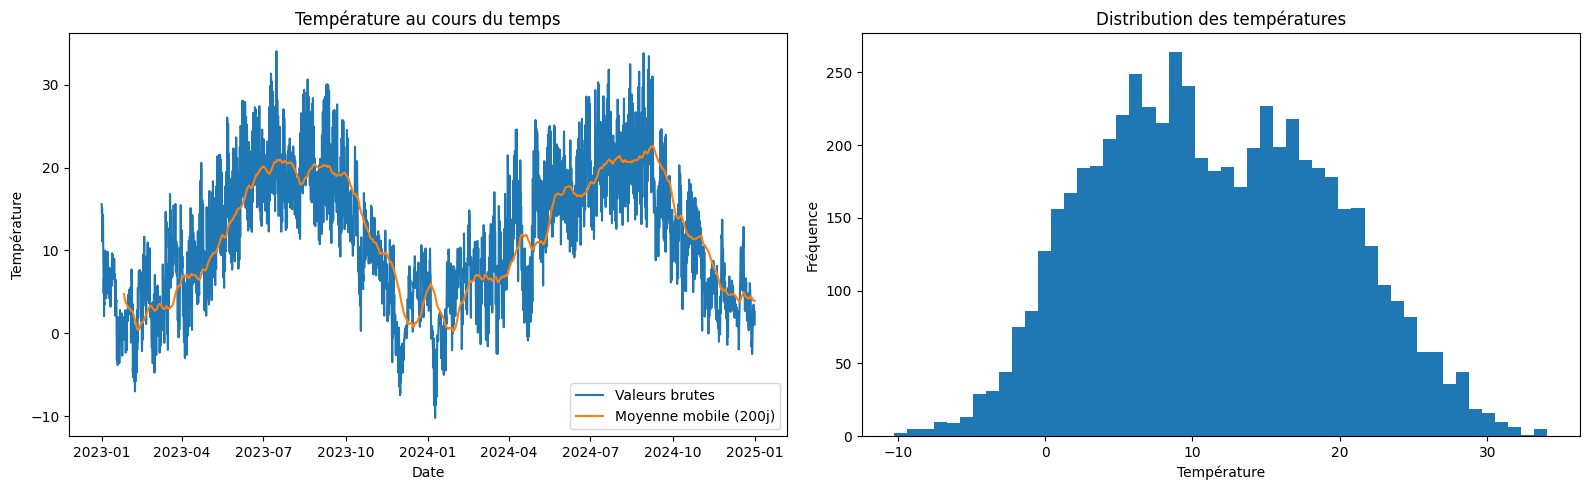

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Premier graphique : s√©rie temporelle
axes[0].plot(df_y.index, df_eda['y'], label='Valeurs brutes')
axes[0].plot(df_y.index, df_eda['y'].rolling(window=200).mean(), label='Moyenne mobile (200j)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temp√©rature')
axes[0].set_title('Temp√©rature au cours du temps')
axes[0].legend()

# Deuxi√®me graphique : histogramme
axes[1].hist(df_y['y'], bins=50)
axes[1].set_title('Distribution des temp√©ratures')
axes[1].set_xlabel('Temp√©rature')
axes[1].set_ylabel('Fr√©quence')

plt.tight_layout()
plt.show()


La s√©rie n‚Äôest pas stationnaire.

On observe une forte saisonnalit√© avec des cycles annuels bien marqu√©s: la moyenne et la variance √©voluent clairement au fil du temps, ce qui viole les conditions de stationnarit√©.

Le graphique de droite montre une distribution bimodale des temp√©ratures avec deux pics distincts. Le premier pic se situe autour de 5-10¬∞C (probablement les temp√©ratures hivernales) et le second autour de 15-20¬∞C (temp√©ratures estivales).

Cette forme bimodale confirme la forte saisonnalit√© observ√©e dans la s√©rie temporelle : les temp√©ratures se regroupent principalement autour de deux valeurs caract√©ristiques correspondant aux saisons froides et chaudes.

La distribution couvre une amplitude importante (-10¬∞C √† 30¬∞C), ce qui illustre bien la variabilit√© saisonni√®re importante de cette s√©rie de temp√©ratures. Cette caract√©ristique bimodale est typique des donn√©es climatiques dans les r√©gions √† saisons marqu√©es.

 > On observe que les temp√©ratures descendent parfois proches de 0¬∞C, voire en dessous. Cela signifie que l‚Äôindicateur MAPE pourra √™tre trompeur lors de l‚Äô√©valuation des mod√®les, car il devient tr√®s √©lev√© pour les valeurs basses. Il sera donc plus pertinent d‚Äôinterpr√©ter le MAE (erreur absolue moyenne en ¬∞C) pour juger la qualit√© des pr√©dictions.

In [14]:
Q1 = df_eda.quantile(0.25)
Q3 = df_eda.quantile(0.75)
IQR = Q3 - Q1
outliers = (df_eda < (Q1 - 1.5 * IQR)) | (df_eda > (Q3 + 1.5 * IQR))


In [15]:
serie_corrigee = df_y.copy()
serie_corrigee[outliers] = np.nan
serie_corrigee = serie_corrigee.interpolate()

nb_outliers = outliers.sum().iloc[0]

print(f"Nombre d'outliers d√©tect√©s : {nb_outliers}")
print(f"Pourcentage : {(nb_outliers/len(serie_corrigee))*100:.2f}%")



Nombre d'outliers d√©tect√©s : 0
Pourcentage : 0.00%


Aucun outlier n‚Äôa √©t√© d√©tect√© dans notre s√©rie. Cela signifie que toutes les valeurs sont coh√©rentes avec la distribution globale des donn√©es.

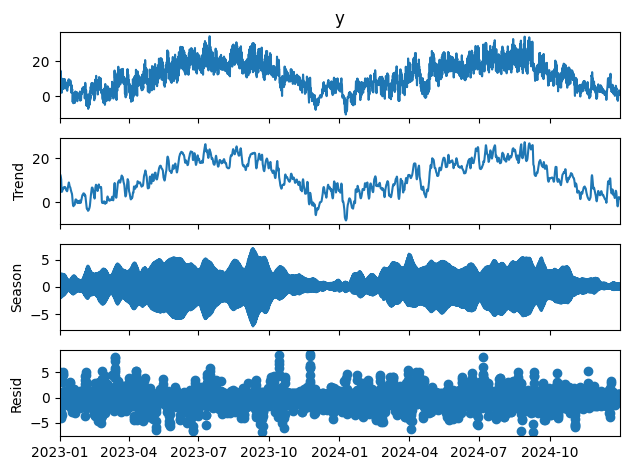

In [16]:
stl = STL(
    df_eda['y'],
    period=8,
    seasonal=13,
    robust=True
)
r_stl = stl.fit()

r_stl.plot()
plt.show()

- La tendance montre une √©volution globale, avec une mont√©e puis une descente sur la p√©riode.
- La saisonnalit√© est bien marqu√©e et r√©guli√®re.
- Les r√©sidus sont centr√©s autour de z√©ro, sans motif √©vident, ce qui indique que la STL a bien extrait la tendance et la saisonnalit√©.

In [17]:
check_stationarity(r_stl.resid)


‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
üìä TEST ADF - AUGMENTED DICKEY-FULLER
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
Hypoth√®se nulle (H0) : La s√©rie a une racine unitaire (non stationnaire)

Statistique ADF : -12.2734
p-value : 0.0000
Valeurs critiques :
  1%% : -3.4315
  5%% : -2.8620
  10%% : -2.5670

Conclusion ADF : Stationnaire (Œ±=0.05)


np.True_

In [18]:
check_stationarity_kpss(r_stl.resid)


‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
üìà TEST KPSS - KWiatkowski-Phillips-Schmidt-Shin
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
Hypoth√®se nulle (H0) : La s√©rie est stationnaire autour d'une constante

Statistique KPSS : 0.0602
p-value : 0.1000
Valeurs critiques :
  10%% : 0.3470
  5%% : 0.4630
  2.5%% : 0.5740
  1%% : 0.7390

Conclusion KPSS : Stationnaire (Œ±=0.05)


np.True_

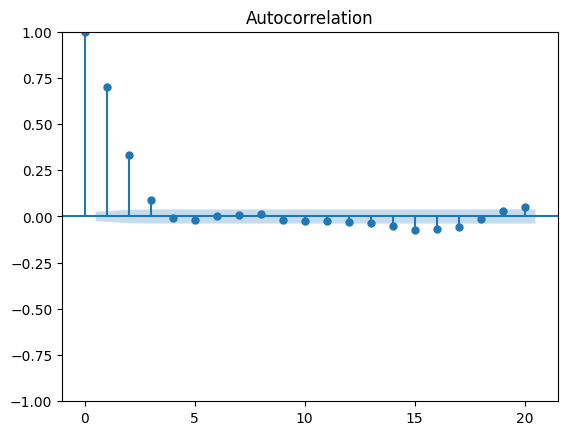

In [19]:
residus = r_stl.resid.dropna()

# Graphique ACF
plot_acf(residus, lags=20)
plt.show()

**Autocorr√©lation significative** : les 4 premiers lags d√©passent les bandes de confiance (lignes horizontales). Cela signifie qu'il reste de la structure temporelle dans les r√©sidus que la d√©composition STL n'a pas captur√©e.

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
dernier_lag = 10

test_result = acorr_ljungbox(residus, lags=10, return_df=True)
pvalue = test_result['lb_pvalue'].iloc[-1]
print(f"Ljung-Box (lag={dernier_lag}) : p-value = {pvalue:.4f}")
if pvalue < 0.05:
    print("‚Üí R√©sidus autocorr√©l√©s : le mod√®le n'explique pas toute la structure.")
else:
    print("‚Üí R√©sidus = bruit blanc : pas d'autocorr√©lation d√©tect√©e.")

Ljung-Box (lag=10) : p-value = 0.0000
‚Üí R√©sidus autocorr√©l√©s : le mod√®le n'explique pas toute la structure.


Cette situation n'est pas n√©cessairement probl√©matique en soi, mais repr√©sente plut√¥t une opportunit√© d'am√©lioration. Les r√©sidus autocorr√©l√©s contiennent des informations pr√©dictives pr√©cieuses qui peuvent √™tre exploit√©es pour enrichir les pr√©visions finales.

La solution la plus recommand√©e consiste √† adopter une approche hybride STL-ARIMA qui tire parti de la structure autocorr√©lative des r√©sidus.

## 4. Pr√©paration des Donn√©es pour ML

Approche Hybrid STL + Model

### 4.1 Nettoyage des donn√©es

In [21]:
df_eda = nan_interpolation_linear(df_eda, 'y')
df_eda = nan_interpolation_linear(df_eda, 'relative_humidity_2m')

### 4.2 Division train/validation/test

In [22]:
train_size = int(len(df_y) * 0.9)

In [23]:
df_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

train = df_model[:train_size]
test = df_model[train_size:]

print("DATA:", train.shape, test.shape)

DATA: (5263, 4) (585, 4)


## 5. Mod√©lisation - M√©thodes Statistiques

Les approches √† ARIMA SARIMA ET SARIMAX on ete tester avec un recherche des parametre faite avec l'aide de optuna et une decoupe de dataset manuelle et et avec timesplit s√©ries. Tout a echouer a des scores MAPE de plus de 200%

### ARIMA

Application du mod√®le ARIMA sur les donn√©es pr√©trait√©es, sans d√©composition pr√©alable par STL.

In [24]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 1)
        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [26]:
arima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(0,0,0,0),
            trend=study.best_params['trend']
        )
r_arima = arima.fit()

In [27]:
p_arima = r_arima.get_forecast(steps=len(test))

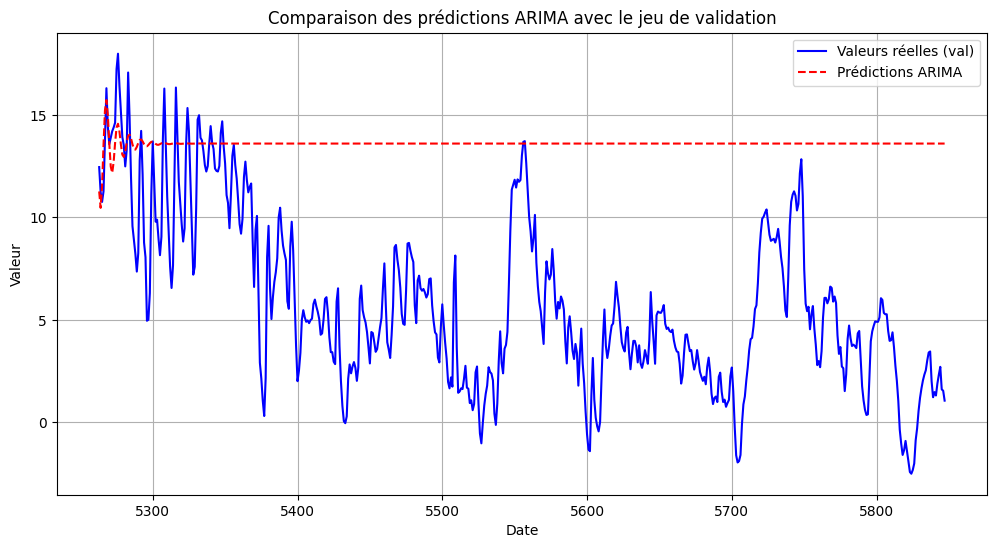

In [28]:
match_val_predict(p_arima.predicted_mean, test['y'], 'ARIMA')

In [29]:
m_arima = metrics_result(p_arima.predicted_mean, test['y'])

MAPE : 881.7%
MAE : 7.95
RMSE : 8.86
R¬≤ : -3.547


Le mod√®le ARIMA ne parvient pas √† suivre la variabilit√© des valeurs r√©elles: il pr√©dit une valeur quasi constante, ce qui explique les erreurs √©lev√©es observ√©es (MAE: 7.95, RMSE: 8.86, MAPE: 881.73%).

In [30]:
logger_manager.log_training('ARIMA', study.best_value, study.best_params, m_arima)

‚úÖ Logged ARIMA training parameters


### SARIMA

Application du mod√®le SARIMA sur les donn√©es pr√©trait√©es, sans d√©composition pr√©alable par STL.

In [31]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [32]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [33]:
sarima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'], study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend']
        )
r_sarima = sarima.fit()

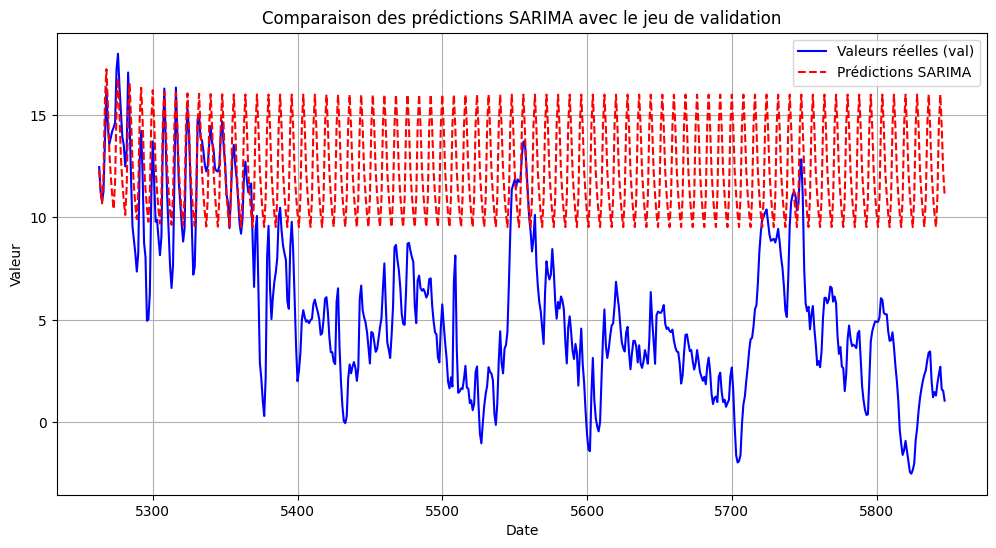

In [34]:
p_sarima = r_sarima.get_forecast(steps=len(test))

match_val_predict(p_sarima.predicted_mean, test['y'], 'SARIMA')

In [35]:
m_sarima = metrics_result(p_sarima.predicted_mean, test['y'])

MAPE : 690.0%
MAE : 6.83
RMSE : 7.84
R¬≤ : -2.558


Le mod√®le SARIMA ne parvient pas √† suivre la variabilit√© des valeurs r√©elles : ses pr√©dictions restent quasi constantes et ne capturent ni les fluctuations ni les tendances du jeu de validation. Cela montre que SARIMA, dans sa configuration actuelle, n‚Äôest pas adapt√© √† la complexit√© ou √† la forte variabilit√© de cette s√©rie temporelle

In [36]:
logger_manager.log_training('SARIMA', study.best_value, study.best_params, m_sarima)

‚úÖ Logged SARIMA training parameters


### SARIMAX

Application du mod√®le SARIMAX sur les donn√©es pr√©trait√©es, sans d√©composition pr√©alable par STL.

In [37]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend,
            exog=train_tss['relative_humidity_2m']
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [38]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [39]:
sarimax = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'],  study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend'],
            exog=train['relative_humidity_2m']
        )
r_sarimax = sarima.fit()

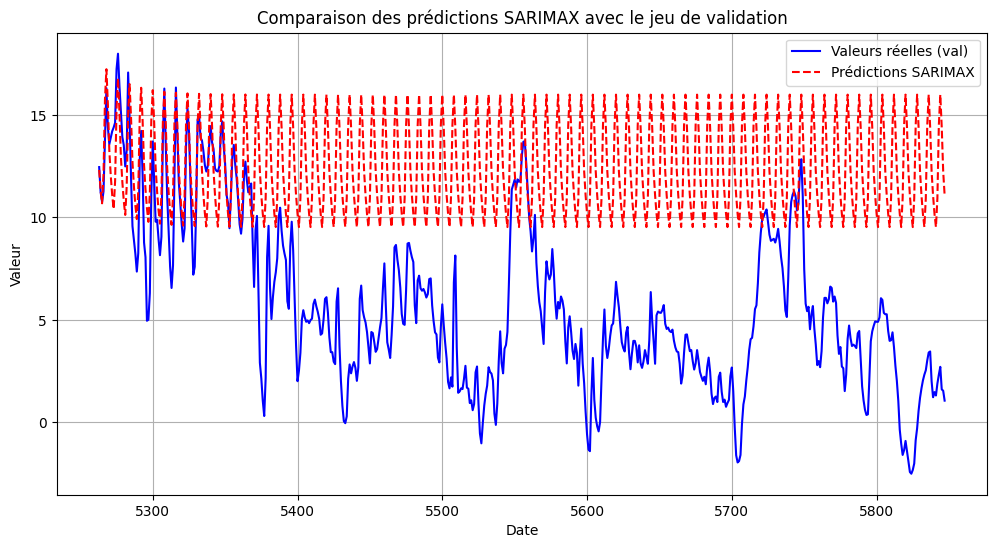

In [40]:
p_sarimax = r_sarimax.get_forecast(steps=len(test))

match_val_predict(p_sarimax.predicted_mean, test['y'], 'SARIMAX')

In [41]:
m_sarimax = metrics_result(p_sarimax.predicted_mean, test['y'])

MAPE : 690.0%
MAE : 6.83
RMSE : 7.84
R¬≤ : -2.558


In [42]:
logger_manager.log_training('SARIMAX', study.best_value, study.best_params, m_sarimax)

‚úÖ Logged SARIMAX training parameters


### STL+ARIMA

Au vu des limites du mod√®le SARIMA √† capturer la variabilit√© des donn√©es et des r√©sultats des tests de diagnostic, l'approche hybride STL-ARIMA est fortement recommand√©e. Les tests r√©v√®lent que :

Analyse des r√©sidus : Le test de Ljung-Box (p-value = 0.0000) confirme que les r√©sidus sont significativement autocorr√©l√©s, indiquant que le mod√®le SARIMA n'explique pas toute la structure temporelle des donn√©es.

Tests de stationnarit√© : Avant d√©composition STL, les r√©sultats sont contradictoires (ADF stationnaire vs KPSS non-stationnaire), sugg√©rant une stationnarit√© de tendance. Apr√®s d√©composition STL, les deux tests concordent (ADF et KPSS stationnaires), confirmant que STL am√©liore efficacement les propri√©t√©s statistiques des donn√©es.

Cette concordance des tests post-STL et la persistance d'autocorr√©lation dans les r√©sidus justifient l'adoption d'une approche hybride pour mieux capturer les patterns complexes de la s√©rie temporelle.

In [43]:
stl_arima_train = STL(train['y'], period=8)
r_train_stl_arima = stl_arima_train.fit()

stl_arima_test = STL(test['y'], period=8)
r_test_stl_arima = stl_arima_test.fit()

In [44]:
train_stl_arima = pd.DataFrame(r_train_stl_arima.resid)
test_stl_arima = pd.DataFrame(r_test_stl_arima.resid)

train_stl_arima = train_stl_arima.rename(columns={'resid': 'y'})
test_stl_arima = test_stl_arima.rename(columns={'resid': 'y'})


In [45]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train_stl_arima):
        train_tss, val_tss = train_stl_arima.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss,
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend,
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [46]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [47]:
stl_arima = SARIMAX(
    train_stl_arima,
    order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
    seasonal_order=(0, 0, 0, 0),
    trend=study.best_params['trend']
)
r_stl_arima = stl_arima.fit()


C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
p_stl_arima = r_stl_arima.get_forecast(steps=len(test))

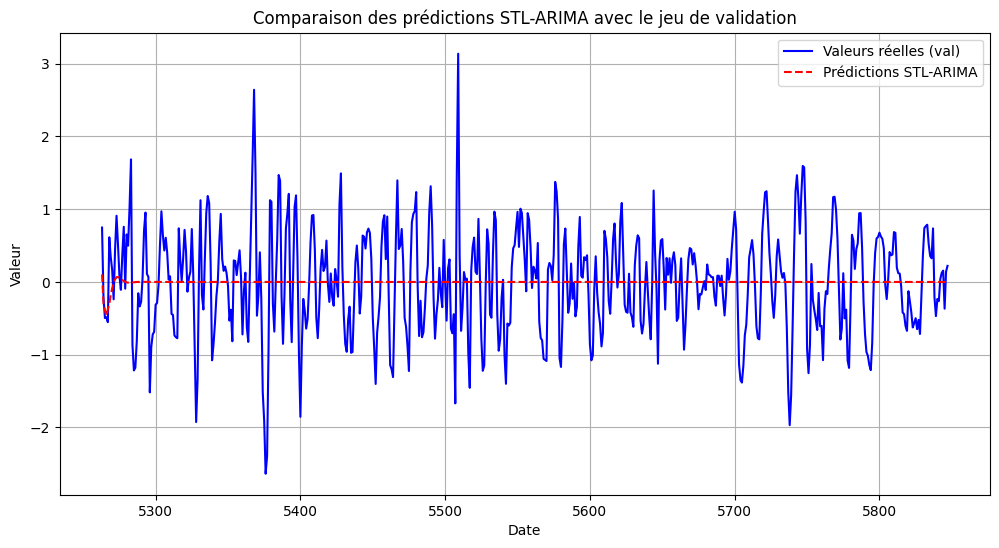

In [49]:
match_val_predict(p_stl_arima.predicted_mean, test_stl_arima['y'], 'STL-ARIMA')

In [50]:
m_stl_arima = metrics_result(p_stl_arima.predicted_mean, test_stl_arima['y'])

MAPE : 99.6%
MAE : 0.56
RMSE : 0.71
R¬≤ : 0.002


Le mod√®le STL-ARIMA s'av√®re inadapt√© pour cette s√©rie temporelle.
Les m√©triques catastrophiques (MAPE 99.6%, R¬≤ ‚âà 0) confirment
l'√©chec total du mod√®le √† capturer les dynamiques temporelles.

‚Üí Justification solide pour passer aux m√©thodes ML (XGBoost/LSTM)
‚Üí Baseline de comparaison √©tablie (tout mod√®le > 0.002 R¬≤ sera meilleur)

In [51]:
logger_manager.log_training('STL-ARIMA', study.best_value, study.best_params, m_stl_arima)

‚úÖ Logged STL-ARIMA training parameters


## 6. Mod√©lisation - Machine Learning

In [52]:
df_ml_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

df_ml_model.drop('unique_id', axis=1, inplace=True)

train_ml = df_ml_model[:train_size].copy()
test_ml = df_ml_model[train_size:].copy()

train_ml_without_exog = train_ml.drop('relative_humidity_2m', axis=1).copy()
test_ml_without_exog = test_ml.drop('relative_humidity_2m', axis=1).copy()

print("DATA:", train.shape, test.shape)

DATA: (5263, 4) (585, 4)


### XGBoost

In [53]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Param√®tres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Param√®tres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Cr√©er les lag features
        lag_transformer = LagFeatures(
            variables= ['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entra√Ænement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Pr√©diction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [54]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 89. Best value: 1.84: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:10<00:00,  1.43it/s]  


In [55]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

9

In [56]:
train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_ml_numeric).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y'])
y_train_xgb = train_transformed_xgb['y']

X_test_xgb = test_transformed_xgb.drop(columns=['y'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(**best_params, random_state=42)
xgb_r.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08156815640000825, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=148, n_jobs=None,
             num_parallel_tree=None, ...)

In [57]:
p_xgb = xgb_r.predict(X_test_xgb)

In [58]:
m_xgb = metrics_result(p_xgb, y_test_xgb)

MAPE : 51.5%
MAE : 0.74
RMSE : 0.98
R¬≤ : 0.942


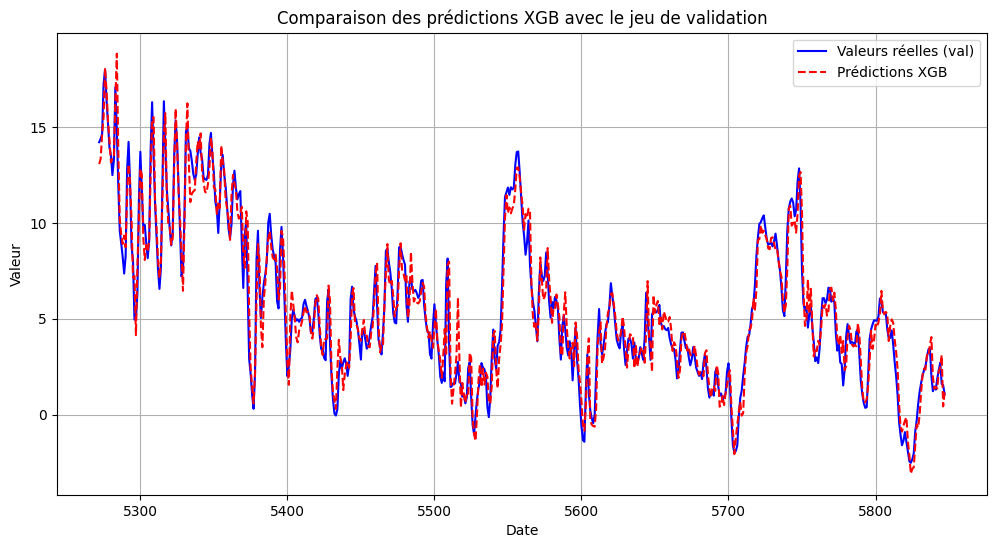

In [59]:
match_val_predict(p_xgb, y_test_xgb, 'XGB')

Les scores sont tr√®s bons et la courbe de validation montre que le mod√®le XGB g√©n√©ralise bien sur ce jeu. Il faut cependant rester attentif √† l‚Äôoverfitting, et v√©rifier que la s√©paration train/val est correcte et qu‚Äôil n‚Äôy a pas eu de fuite de donn√©es.Le MAPE √©lev√© indique que le mod√®le a plus de mal sur les petites valeurs.

In [60]:
logger_manager.log_training('XGB', study.best_value, study.best_params, m_xgb)

‚úÖ Logged XGB training parameters


### XGBoost + Exog√®ne

In [61]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Param√®tres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Param√®tres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    train_ml_numeric = train_ml.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Cr√©er les lag features
        lag_transformer = LagFeatures(
            variables= ['y', 'relative_humidity_2m'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_val = val_transformed['y']

        # Entra√Ænement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Pr√©diction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [62]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 61. Best value: 1.90017: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:35<00:00,  1.04it/s]


In [63]:
best_n_lags = study.best_params['n_lags']
best_params = study.best_params.copy()
best_params.pop('n_lags', None)

9

In [64]:
train_ml_numeric = train_ml.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y', 'relative_humidity_2m'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_ml_numeric).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_train_xgb = train_transformed_xgb['y']

X_test_xgb = test_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(**best_params, random_state=42)
xgb_r.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07344280797762961, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=233, n_jobs=None,
             num_parallel_tree=None, ...)

In [65]:
p_xgb = xgb_r.predict(X_test_xgb)

In [66]:
m_xgb = metrics_result(p_xgb, y_test_xgb)

MAPE : 57.7%
MAE : 0.78
RMSE : 1.03
R¬≤ : 0.936


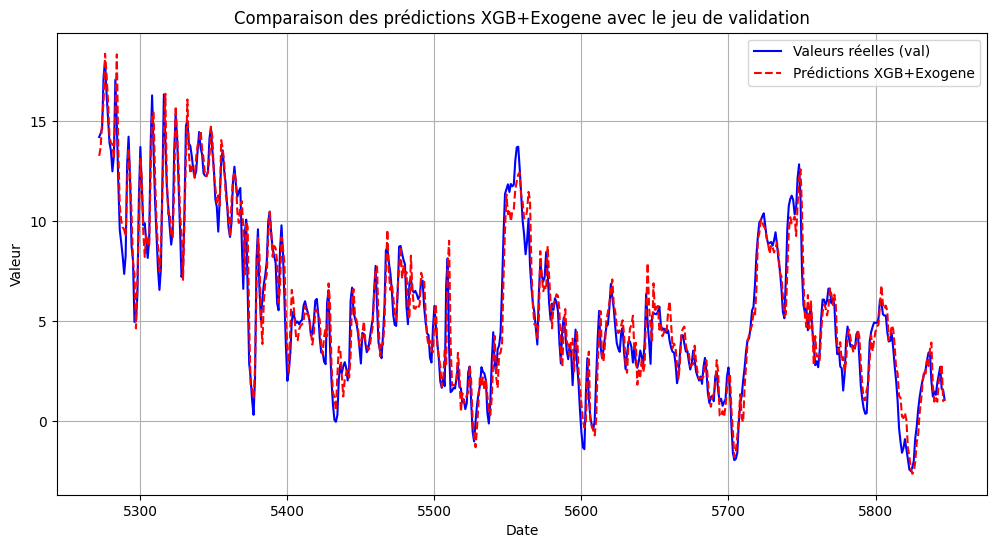

In [67]:
match_val_predict(p_xgb, y_test_xgb, 'XGB+Exogene')

L'exp√©rimentation avec variables exog√®nes a √©t√© men√©e mais n'a pas apport√© de gain de performance. Cela sugg√®re que l'information pertinente est d√©j√† capt√©e par les lags de la temp√©rature.

In [68]:
logger_manager.log_training('XGB+Exogene', study.best_value, study.best_params, m_xgb )

‚úÖ Logged XGB+Exogene training parameters


### Random Forest

In [69]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Param√®tres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Param√®tres Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Cr√©er les lag features
        lag_transformer = LagFeatures(
            variables=['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entra√Ænement
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            max_samples=max_samples,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Pr√©diction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)

In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 42. Best value: 2.19392: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [09:20<00:00,  5.60s/it]


In [71]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

10

In [72]:
train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

rf_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_rf = rf_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_rf = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_rf = rf_transformer.transform(test_ml_numeric).iloc[best_n_lags:].dropna()

X_train_rf = train_transformed_rf.drop(columns=['y'])
y_train_rf = train_transformed_rf['y']

X_test_rf = test_transformed_rf.drop(columns=['y'])
y_test_rf = test_transformed_rf['y']

r_rf = RandomForestRegressor(**best_params, random_state=42)
r_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=8, max_features=0.963070938397881,
                      max_samples=0.9855759887644548, n_estimators=187,
                      random_state=42)

In [73]:
p_rf = r_rf.predict(X_test_rf)

In [74]:
m_rf = metrics_result(p_rf, y_test_rf)

MAPE : 47.3%
MAE : 0.76
RMSE : 1.02
R¬≤ : 0.937


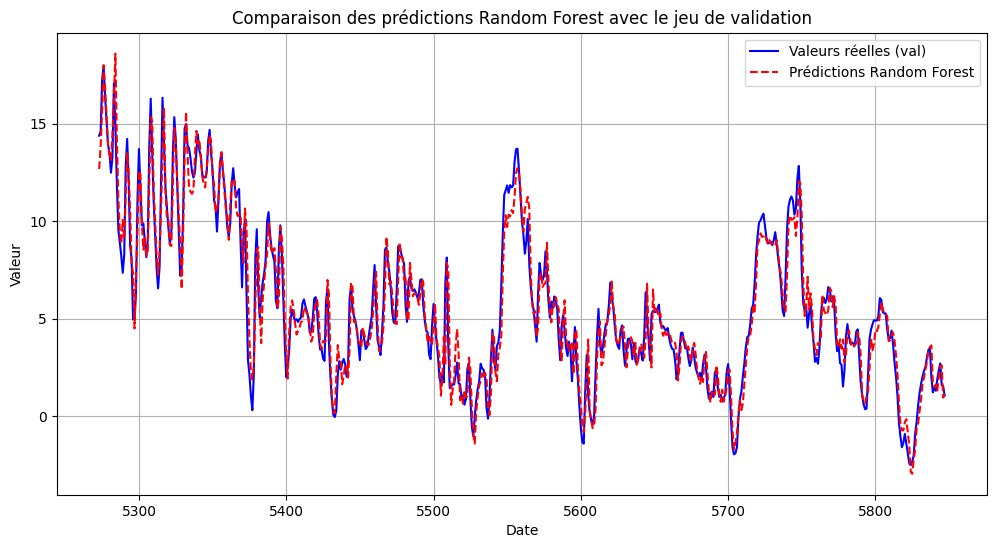

In [75]:
match_val_predict(p_rf, y_test_rf, 'Random Forest')

Le Random Forest capture tr√®s bien la dynamique de la s√©rie temporelle, mais il faut rester prudent avec l‚Äôinterpr√©tation du MAPE dans ce contexte. Les autres m√©triques et la visualisation montrent que le mod√®le est performant sur ce jeu de validation.

In [76]:
logger_manager.log_training('Random Forest', study.best_value, study.best_params, m_rf )

‚úÖ Logged Random Forest training parameters
